# Generating Euclidean TSP using NetworkX

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
%matplotlib notebook
sns.set()

## Undirected Graphs

In [21]:
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(0,4),(2,0)])

<IPython.core.display.Javascript object>


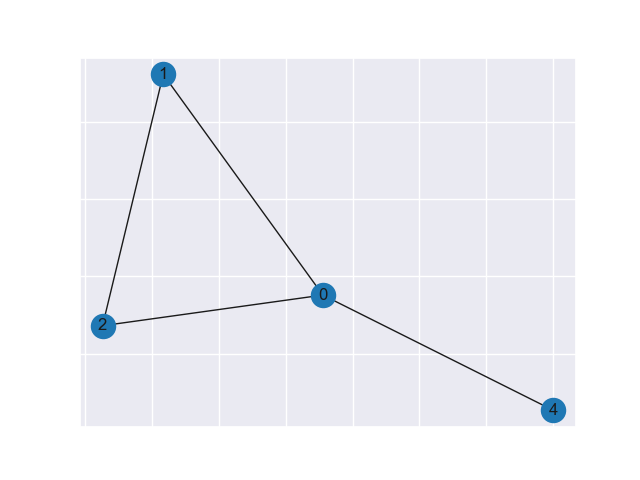

In [22]:
plt.figure()
nx.draw_networkx(G)

## Directed Graph

In [23]:
G1 = nx.DiGraph()
G1.add_edge(1,2)
G1.add_edge(1,3)

<IPython.core.display.Javascript object>


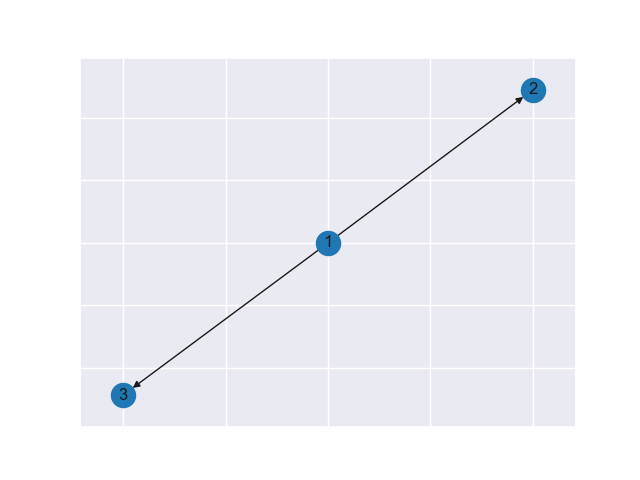

In [24]:
plt.figure()
nx.draw_networkx(G1)

# Weighted Graph

In [25]:
G_weighted = nx.Graph()

# Add a node to a specific position
G.add_node(0, pos = (1,1))
G.add_node(1, pos = (1,2))
G.add_node(2, pos = (2,4))
G.add_node(4, pos = (3,4))

# Add edges with costs
G.add_edge(0,1, weight=20, relation='friend')
G.add_edge(1,2, weight=30, relation='enemy')
G.add_edge(0,2, weight=10, relation='enemy')
G.add_edge(0,4, weight=100, relation='friend')

# Extract weights and positions
weights = nx.get_edge_attributes(G, 'weight')
pos = nx.get_node_attributes(G, 'pos')
relation = nx.get_edge_attributes(G, 'relation')

# Key

<IPython.core.display.Javascript object>


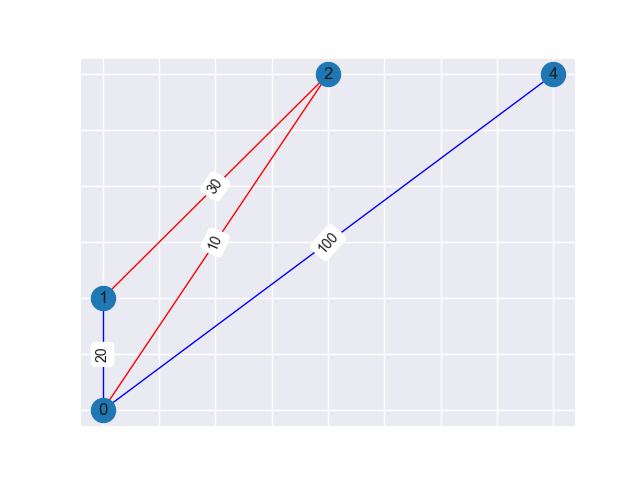

In [26]:
plt.figure()
dic = {'enemy':'red', 'friend':'blue'}
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
nx.draw_networkx(G,pos, edge_color=[dic[x] for x in relation.values()])

## Euclidean TSP Instance

1. Make a distance function that takes in two points $(x_0, y_0)$ and $(x_1, y_1)$
2. Initialise an empty graph
3. Randomly generate positions on a 2D plane and allocate these points as nodes
4. Create a complete graph by connecting all edges together and make the cost the euclidean distance between the two points

In [27]:
# Function to construct euclidean distances
def distance(i, j):
    """ Function to compute distances"""
    if isinstance(i, tuple) and isinstance(j, tuple):
        dx = j[0] - i[0]
        dy = j[1] - i[1]
        return math.sqrt(dx*dx + dy*dy)
    else:
        raise TypeError('Incorrect Type - Please feed a tuple of coordinates')

Algorithm to produce the network

In [28]:
# Number of cities
n = 4
V=range(n)

# Initialise empty graph
G = nx.Graph()

# Build nodes
nodes = [(i,{'pos':tuple(np.random.random(2))}) for i in V]
G.add_nodes_from(nodes)

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Add edges
for i in V:
    for j in V:
        if i != j:
            G.add_edge(i, j, cost=distance(pos[i],pos[j]))

Build a network according to `networkx`

<IPython.core.display.Javascript object>


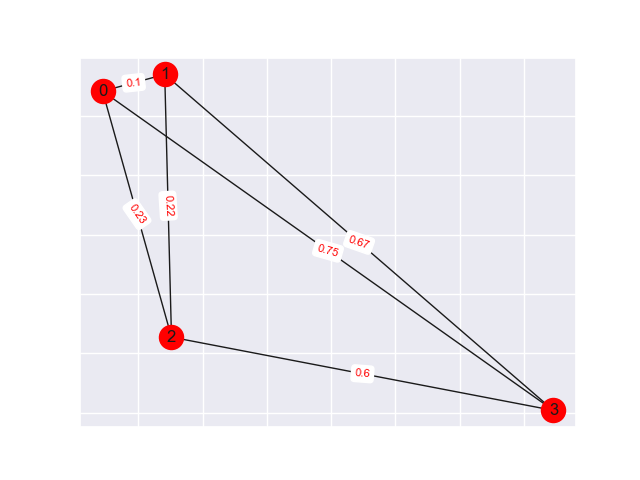

In [72]:
# Draw network
plt.figure()
# Extract costs
costs = nx.get_edge_attributes(G, 'cost')

# If you want to add edgelabels
for edge in G.edges():
    # Create a new attribute in the edge
    G[edge[0]][edge[1]]['cost_label'] = np.round(G[edge[0]][edge[1]]['cost'],2)

cost_labels = nx.get_edge_attributes(G, 'cost_label')

# Draw the edge labels on the graph
nx.draw_networkx_edge_labels(
    G, 
    pos, 
    edge_labels=cost_labels, 
    font_size=8,
    font_color='red'
)

# Draw the graph
nx.draw_networkx(
    G, 
    pos,
    node_color='red'
)

Great! Now lets wrap this up into a Python function that we can use to generate a generic TSP instance

In [ ]:
def generate_euclidean_graph(G, )